## Import Libraries

In [3]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## Display Settings

In [4]:
pd.set_option("display.max_columns", None)

In [5]:
sklearn.set_config(transform_output="pandas")

In [6]:
warnings.filterwarnings("ignore")

## Read the Data

In [7]:
path = r"C:\Users\Paulastha Maitra\Desktop\flight\data\train.csv"

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6695 non-null   object 
 1   date_of_journey  6695 non-null   object 
 2   source           6695 non-null   object 
 3   destination      6695 non-null   object 
 4   dep_time         6695 non-null   object 
 5   arrival_time     6695 non-null   object 
 6   duration         6695 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6695 non-null   object 
 9   price            6695 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 523.2+ KB


In [9]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## Transformation Operations

In [10]:
X_train.airline

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6695, dtype: object

In [11]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6690,0.0,0.0,1.0,0.0,0.0
6691,1.0,0.0,0.0,0.0,0.0
6692,0.0,0.0,1.0,0.0,0.0
6693,0.0,0.0,0.0,0.0,1.0


date of jpurney

In [12]:
X_train.date_of_journey

0       2019-03-21
1       2019-03-27
2       2019-03-09
3       2019-06-12
4       2019-03-12
           ...    
6690    2019-03-21
6691    2019-05-01
6692    2019-06-01
6693    2019-06-24
6694    2019-03-01
Name: date_of_journey, Length: 6695, dtype: object

In [13]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])


,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.176471,0.500000,0.169492
1,0.000000,0.235294,0.333333,0.220339
2,0.000000,0.058824,0.833333,0.067797
3,1.000000,0.882353,0.333333,0.872881
4,0.000000,0.117647,0.166667,0.093220
...,...,...,...,...
6690,0.000000,0.176471,0.500000,0.169492
6691,0.666667,0.529412,0.333333,0.516949
6692,1.000000,0.764706,0.833333,0.779661
6693,1.000000,1.000000,0.000000,0.974576


source & destination

In [14]:

X_train.source

0       Banglore
1          Delhi
2       Banglore
3        Kolkata
4       Banglore
          ...   
6690       Delhi
6691     Kolkata
6692       Delhi
6693       Delhi
6694    Banglore
Name: source, Length: 6695, dtype: object

In [15]:
X_train.destination

0       New Delhi
1          Cochin
2       New Delhi
3        Banglore
4       New Delhi
          ...    
6690       Cochin
6691     Banglore
6692       Cochin
6693       Cochin
6694    New Delhi
Name: destination, Length: 6695, dtype: object

In [16]:

location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Banglore,New Delhi
1,Delhi,Cochin
2,Banglore,New Delhi
3,Kolkata,Banglore
4,Banglore,New Delhi
...,...,...
6690,Delhi,Cochin
6691,Kolkata,Banglore
6692,Delhi,Cochin
6693,Delhi,Cochin


In [24]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-0.857930,-0.736484
1,1.065418,1.061694
2,-0.857930,-0.736484
3,-0.203928,-0.224351
4,-0.857930,-0.736484
...,...,...
6690,1.065418,1.061694
6691,-0.203928,-0.224351
6692,1.065418,1.061694
6693,1.065418,1.061694


In [25]:
## custom transformation
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [26]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
6690,1,0
6691,1,0
6692,1,0
6693,1,0


In [27]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-0.857930,-0.736484,0,1
1,1.065418,1.061694,1,0
2,-0.857930,-0.736484,0,1
3,-0.203928,-0.224351,1,0
4,-0.857930,-0.736484,0,1
...,...,...,...,...
6690,1.065418,1.061694,1,0
6691,-0.203928,-0.224351,1,0
6692,1.065418,1.061694,1,0
6693,1.065418,1.061694,1,0


In [28]:
X_train.dep_time

0       08:55:00
1       17:30:00
2       11:40:00
3       09:25:00
4       22:55:00
          ...   
6690    10:45:00
6691    09:25:00
6692    14:00:00
6693    07:55:00
6694    11:50:00
Name: dep_time, Length: 6695, dtype: object

In [29]:

X_train.arrival_time

0       19:10:00
1       04:25:00
2       14:35:00
3       18:30:00
4       07:40:00
          ...   
6690    18:50:00
6691    18:30:00
6692    19:00:00
6693    13:25:00
6694    08:55:00
Name: arrival_time, Length: 6695, dtype: object

In [30]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,08:55:00,19:10:00
1,17:30:00,04:25:00
2,11:40:00,14:35:00
3,09:25:00,18:30:00
4,22:55:00,07:40:00
...,...,...
6690,10:45:00,18:50:00
6691,09:25:00,18:30:00
6692,14:00:00,19:00:00
6693,07:55:00,13:25:00


In [31]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,1.000000,0.826087,0.181818
1,0.739130,0.545455,0.173913,0.454545
2,0.478261,0.727273,0.608696,0.636364
3,0.391304,0.454545,0.782609,0.545455
4,0.956522,1.000000,0.304348,0.727273
...,...,...,...,...
6690,0.434783,0.818182,0.782609,0.909091
6691,0.391304,0.454545,0.782609,0.545455
6692,0.608696,0.000000,0.826087,0.000000
6693,0.304348,1.000000,0.565217,0.454545


In [37]:
## custom transformation
## part of the day
def part_of_day(X,morning=4,noon=12,evening=16,night=20):
    columns=X.columns.to_list()
    X_temp=X.assign(**{
        col:pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_thr_day":np.select(
                [X_temp.loc[:,col].between(morning,noon,inclusive="left"),
                 X_temp.loc[:,col].between(noon,evening,inclusive="left"),
                 X_temp.loc[:,col].between(evening,night,inclusive="left")],
                ["morning","afternoon","evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=part_of_day).fit_transform(time_subset)
        
    

,dep_time_part_of_thr_day,arrival_time_part_of_thr_day
0,morning,evening
1,evening,morning
2,morning,afternoon
3,morning,evening
4,night,morning
...,...,...
6690,morning,evening
6691,morning,evening
6692,afternoon,evening
6693,morning,afternoon


In [38]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)


,dep_time_part_of_thr_day,arrival_time_part_of_thr_day
0,1.000000,0.667335
1,0.202685,0.952906
2,1.000000,0.000000
3,1.000000,0.667335
4,0.174101,0.952906
...,...,...
6690,1.000000,0.667335
6691,1.000000,0.667335
6692,0.000000,0.667335
6693,1.000000,0.000000


In [39]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_thr_day,arrival_time_part_of_thr_day
0,0.347826,1.000000,0.826087,0.181818,1.000000,0.667335
1,0.739130,0.545455,0.173913,0.454545,0.202685,0.952906
2,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000
3,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335
4,0.956522,1.000000,0.304348,0.727273,0.174101,0.952906
...,...,...,...,...,...,...
6690,0.434783,0.818182,0.782609,0.909091,1.000000,0.667335
6691,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335
6692,0.608696,0.000000,0.826087,0.000000,0.000000,0.667335
6693,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000


In [40]:
X_train.duration

0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6695, dtype: int64

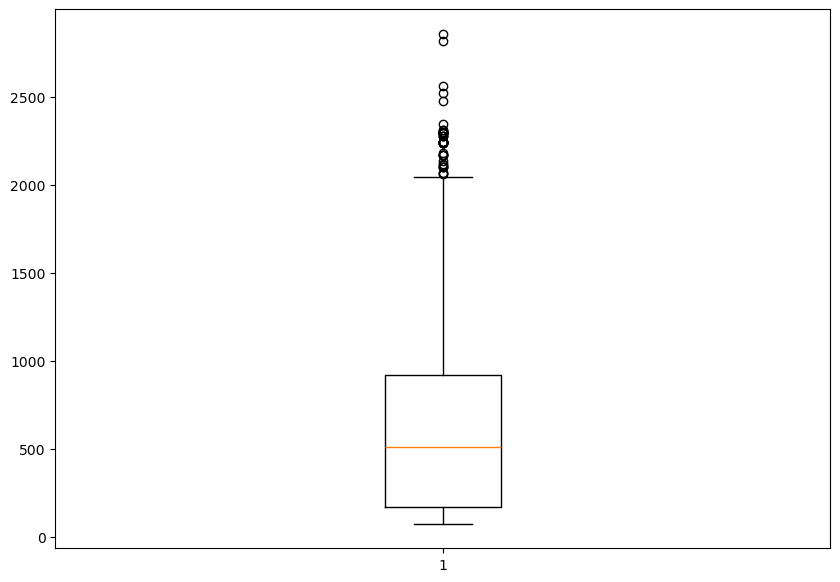

In [42]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,7))
plt.boxplot(X_train.duration)
plt.show()

In [77]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [78]:
duration_category(X_train.loc[:,["duration"]])

,duration_cat
0,long
1,long
2,short
3,long
4,long
...,...
6690,long
6691,long
6692,medium
6693,medium


In [46]:
(
    X_train
    .duration
    .quantile([0.25,0.75,0.50])
    .values
    .reshape(-1,1)
)    

array([[170. ],
       [922.5],
       [510. ]])

In [57]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)  

In [62]:
RBFPercentileSimilarity().fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000,0.000000e+00,0.0
1,0.000000,0.000000e+00,0.0
2,0.082085,0.000000e+00,0.0
3,0.000000,6.293989e-54,0.0
4,0.000000,1.691898e-10,0.0
...,...,...,...
6690,0.000000,0.000000e+00,0.0
6691,0.000000,6.293989e-54,0.0
6692,0.000000,0.000000e+00,0.0
6693,0.000000,0.000000e+00,0.0


In [79]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [81]:
is_over(X_train.loc[:,["duration"]])

,duration_over_1000
0,0
1,0
2,0
3,0
4,0
...,...
6690,1
6691,0
6692,0
6693,0


In [82]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])
duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])
duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.364262,-0.107976,-0.107799,2.0,0,-0.033916
1,-0.364262,-0.107976,-0.107799,2.0,0,0.046422
2,2.373008,-0.107976,-0.107799,0.0,0,-0.917631
3,-0.364262,-0.107976,-0.107799,2.0,0,-0.174507
4,-0.364262,-0.107975,-0.107799,2.0,0,-0.214676
...,...,...,...,...,...,...
6690,-0.364262,-0.107976,-0.107799,2.0,1,2.597145
6691,-0.364262,-0.107976,-0.107799,2.0,0,-0.174507
6692,-0.364262,-0.107976,-0.107799,1.0,0,-0.666576
6693,-0.364262,-0.107976,-0.107799,1.0,0,-0.606322


total stops

In [83]:
X_train.total_stops

0       1.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
6690    2.0
6691    1.0
6692    1.0
6693    1.0
6694    1.0
Name: total_stops, Length: 6695, dtype: float64

In [84]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
6690,2.0,0
6691,1.0,0
6692,1.0,0
6693,1.0,0


additional info

In [85]:
X_train.additional_info

0       In-flight meal not included
1       In-flight meal not included
2                           No Info
3                           No Info
4       In-flight meal not included
                   ...             
6690                        No Info
6691                        No Info
6692    In-flight meal not included
6693                        No Info
6694                 1 Long layover
Name: additional_info, Length: 6695, dtype: object

In [86]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
6690,0.0,1.0,0.0
6691,0.0,1.0,0.0
6692,1.0,0.0,0.0
6693,0.0,1.0,0.0


In [87]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [88]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [89]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
6690,0.0,1.0,0.0,0
6691,0.0,1.0,0.0,0
6692,1.0,0.0,0.0,1
6693,0.0,1.0,0.0,0


## Column Transformer

In [90]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_thr_day,time__arrival_time_part_of_thr_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-0.857930,-0.736484,0,1,0.347826,1.000000,0.826087,0.181818,1.000000,0.667335,-0.364262,-0.107976,-0.107799,2.0,0,-0.033916,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.000000,0.235294,0.333333,0.220339,1.065418,1.061694,1,0,0.739130,0.545455,0.173913,0.454545,0.202685,0.952906,-0.364262,-0.107976,-0.107799,2.0,0,0.046422,1.0,0,1.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,1.0,0.000000,0.058824,0.833333,0.067797,-0.857930,-0.736484,0,1,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000,2.373008,-0.107976,-0.107799,0.0,0,-0.917631,0.0,1,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-0.203928,-0.224351,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335,-0.364262,-0.107976,-0.107799,2.0,0,-0.174507,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.000000,0.117647,0.166667,0.093220,-0.857930,-0.736484,0,1,0.956522,1.000000,0.304348,0.727273,0.174101,0.952906,-0.364262,-0.107975,-0.107799,2.0,0,-0.214676,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,1.065418,1.061694,1,0,0.434783,0.818182,0.782609,0.909091,1.000000,0.667335,-0.364262,-0.107976,-0.107799,2.0,1,2.597145,2.0,0,0.0,1.0,0.0,0
6691,1.0,0.0,0.0,0.0,0.0,0.666667,0.529412,0.333333,0.516949,-0.203928,-0.224351,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335,-0.364262,-0.107976,-0.107799,2.0,0,-0.174507,1.0,0,0.0,1.0,0.0,0
6692,0.0,0.0,1.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,1.065418,1.061694,1,0,0.608696,0.000000,0.826087,0.000000,0.000000,0.667335,-0.364262,-0.107976,-0.107799,1.0,0,-0.666576,1.0,0,1.0,0.0,0.0,1
6693,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.974576,1.065418,1.061694,1,0,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000,-0.364262,-0.107976,-0.107799,1.0,0,-0.606322,1.0,0,0.0,1.0,0.0,0


## Feature Selection

In [91]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## All Together

In [92]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.176471,0.169492,-0.857930,-0.736484,-0.364262,2.0,0,-0.033916,1.0,0
1,0.0,1.0,0.0,0.235294,0.220339,1.065418,1.061694,-0.364262,2.0,0,0.046422,1.0,0
2,0.0,0.0,1.0,0.058824,0.067797,-0.857930,-0.736484,2.373008,0.0,0,-0.917631,0.0,1
3,0.0,0.0,0.0,0.882353,0.872881,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1.0,0
4,0.0,1.0,0.0,0.117647,0.093220,-0.857930,-0.736484,-0.364262,2.0,0,-0.214676,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,1.0,0.0,0.176471,0.169492,1.065418,1.061694,-0.364262,2.0,1,2.597145,2.0,0
6691,0.0,0.0,0.0,0.529412,0.516949,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1.0,0
6692,0.0,1.0,0.0,0.764706,0.779661,1.065418,1.061694,-0.364262,1.0,0,-0.666576,1.0,0
6693,0.0,0.0,1.0,1.000000,0.974576,1.065418,1.061694,-0.364262,1.0,0,-0.606322,1.0,0
